## GMM 扩容 + 监督学习


In [1]:
# 确保src目录在Python路径中
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append(os.path.abspath("../"))

# 导入模块
from src.data_utils import filter_anomalous_attributes, identify_attributes, parse_petrel_file
from src.feature_selection import (
    analyze_attribute_correlations,
    analyze_rf_importance_by_group,
)
from src.gmm_clustering import (
    augment_samples_by_pca_mixing,
    encode_cluster_features,
    evaluate_gmm_clusters,
    perform_gmm_clustering,
)
from src.pca_analysis import perform_pca_analysis
from src.regression import (
    build_svr_model,
    predict_with_model,
)

output_dir = "output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


# 设置中文字体
plt.rcParams["font.family"] = "SimHei"  # 黑体 SimHei 支持中文
plt.rcParams["axes.unicode_minus"] = False  # 正常显示负号

## 导入地震数据


In [2]:
data_H6_2_attr = parse_petrel_file("../data/H6-2_attr")

正在解析文件: ../data/H6-2_attr
正在识别文件属性: ../data/H6-2_attr
识别到 END ATTRIBUTES 位于第 31 行
识别到 15 个属性:
  - Average energy
  - Average envelope
  - Average instantaneous frequency
  - Average instantaneous phase
  - Average peak value
  - Geometric mean
  - Half energy
  - Harmonic mean
  - Maximum amplitude
  - Mean amplitude
  - Minimum amplitude
  - Most of
  - RMS amplitude
  - Sum of amplitudes
  - Sum of energy
识别到的列含义: ['X', 'Y', 'Z', 'column', 'row']
数据行有 20 列，列名列表有 20 个


d:\Program2025\attribute_fusion\src\data_utils.py:110: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


成功读取数据，共 51714 行

数据预览:
               X             Y            Z  column  row  Average energy  \
0  688546.288809  3.211900e+06 -2472.896240   128.0  1.0      3538352.25   
1  688596.288809  3.211900e+06 -2475.649902   129.0  1.0      6365790.00   
2  688446.288809  3.211950e+06 -2465.910889   126.0  2.0      9748781.00   
3  688496.288809  3.211950e+06 -2469.487061   127.0  2.0      5062806.00   
4  688546.288809  3.211950e+06 -2472.695801   128.0  2.0      2440221.75   

   Average envelope  Average instantaneous frequency  \
0       3114.544678                        32.982338   
1       3344.748779                        33.155682   
2       4269.621094                        35.096291   
3       3648.766113                        31.971563   
4       2865.032471                        31.293999   

   Average instantaneous phase  Average peak value  Geometric mean  \
0                   -75.810104              -999.0          -999.0   
1                   -86.797714            

## 导入井震数据

使用 xlsx / csv 数据，注意表名为 Sheet1，注意数据需包含表头

请检查 excel 表头和下面代码中的 selected_columns 是否一致


In [3]:
file_H6_2_well = "../data/well_processed.xlsx"
data_H6_2_well = pd.read_excel(file_H6_2_well, sheet_name="Sheet1")

# 只选择 Surface 为 H6-2 的行，并丢弃砂厚为 NaN 的行
data_H6_2_well_selected = (
    data_H6_2_well[data_H6_2_well["Surface"] == "H6-2"]
    .replace(-999, np.nan)
    .dropna(subset=["Thickness of facies(1: Fine sand)"])
    .reset_index(drop=True)
)

data_H6_2_well_selected.head()

X          Y       Z Surface Well  \
0  686325.6  3217019.1 -2649.7    H6-2   A1   
1  686616.5  3217415.2 -2633.0    H6-2  A10   
2  686278.0  3217627.9 -2650.4    H6-2  A11   
3  686149.5  3216665.5 -2642.5    H6-2   A2   
4  685921.1  3216986.2 -2644.7    H6-2   A4   

   Thickness of facies(1: Fine sand)  facies(1: Fine sand)  Average energy  \
0                               0.00                  0.00      89001976.0   
1                               7.87                 45.82      76951152.0   
2                               0.00                  0.00       6199530.0   
3                               0.75                  5.16      88260688.0   
4                               0.00                  0.00      31338386.0   

   Average envelope  Average instantaneous frequency  ...  Average peak value  \
0           11011.2                             21.9  ...                 NaN   
1           11667.5                             25.9  ...                 NaN   
2            2127.4                             49.7  ...                 NaN   
3           12334.4                             21.0  ...                 NaN   
4            5349.9                             25.9  ...                 NaN   

   Half energy  Harmonic mean  Maximum amplitude  Mean amplitude  \
0          5.2        -4573.6            -1763.2         -8415.1   
1          4.0       -43402.7             4934.6         -4832.2   
2          7.2        -1264.8             4551.3           623.9   
3          4.0        -7747.0             1608.4         -7710.8   
4          7.0         3644.1             7899.5          4837.1   

   Minimum amplitude  Most of  RMS amplitude  Sum of amplitudes  Sum of energy  
0           -14124.2 -13431.1         9511.8           -66162.7      718160960  
1           -15217.6 -13626.4         8764.0           -36986.6      724726848  
2            -2246.4   -556.0         2459.4             2576.6       26151754  
3           -15313.4 -14014.2         9393.7           -57804.2      667979712  
4              624.7   4900.9         5553.1            15000.3       97357456  

[5 rows x 21 columns]

## 提取共同属性

In [4]:
# 获取地震属性列表
seismic_attr, _ = identify_attributes("../data/H6-2_attr")

# 提取Excel的属性列表（从第8列开始的所有列）
well_seismic_attr = data_H6_2_well.columns[7:].tolist()

# 计算两个列表的交集
common_attributes = list(set(seismic_attr) & set(well_seismic_attr))

# 打印结果
print(f"地震属性数量: {len(seismic_attr)}")
print(f"Excel属性数量: {len(well_seismic_attr)}")
print(f"共同属性数量: {len(common_attributes)}")
print("\n共同属性列表:")
for attr in common_attributes:
    print(f"- {attr}")

# 筛选出质量良好的属性
good_attributes, anomalous_attributes, attribute_stats = filter_anomalous_attributes(
    seismic_data=data_H6_2_attr,
    well_data=data_H6_2_well_selected,
    common_attributes=common_attributes,
    ratio_threshold=5.0,  # 均值比值阈值
    range_ratio_threshold=10.0,  # 数值范围比值阈值
    std_ratio_threshold=10.0,  # 标准差比值阈值
    output_dir=output_dir,  # 输出图表目录
    verbose=True,  # 打印详细信息
)

print("\n筛选后保留的质量良好属性:")
for attr in good_attributes:
    print(f"- {attr}")

正在识别文件属性: ../data/H6-2_attr
识别到 END ATTRIBUTES 位于第 31 行
识别到 15 个属性:
  - Average energy
  - Average envelope
  - Average instantaneous frequency
  - Average instantaneous phase
  - Average peak value
  - Geometric mean
  - Half energy
  - Harmonic mean
  - Maximum amplitude
  - Mean amplitude
  - Minimum amplitude
  - Most of
  - RMS amplitude
  - Sum of amplitudes
  - Sum of energy
地震属性数量: 15
Excel属性数量: 14
共同属性数量: 14

共同属性列表:
- Half energy
- Average instantaneous phase
- Harmonic mean
- Average peak value
- Average instantaneous frequency
- Mean amplitude
- Average envelope
- Maximum amplitude
- Most of
- Sum of energy
- Sum of amplitudes
- Minimum amplitude
- RMS amplitude
- Average energy
======== 井点数据与地震数据的属性统计比较 ========

共分析了 14 个共同属性
发现 3 个异常属性
保留 11 个质量良好的属性

异常属性及原因:
  - Mean amplitude: 均值比值为负 (-2.7440)
  - Harmonic mean: 标准差比值异常 (123.5894), 数值范围比值异常 (5348.7889)
  - Average peak value: 均值比值异常 (0.0963)


d:\Program2025\attribute_fusion\src\data_utils.py:370: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="属性", y="质量分数", data=plot_df, palette=colors)



筛选后保留的质量良好属性:
- Sum of amplitudes
- Average instantaneous phase
- Sum of energy
- Maximum amplitude
- Minimum amplitude
- Half energy
- Most of
- Average energy
- RMS amplitude
- Average instantaneous frequency
- Average envelope


## PCA 降维 + GMM 聚类


======== PCA降维分析开始 ========
数据集大小: (51714, 20)
处理前特征: (51714, 11)

每列缺失值数量:
  - Sum of amplitudes: 0 (0.00%)
  - Average instantaneous phase: 0 (0.00%)
  - Sum of energy: 0 (0.00%)
  - Maximum amplitude: 225 (0.44%)
  - Minimum amplitude: 197 (0.38%)
  - Half energy: 0 (0.00%)
  - Most of: 0 (0.00%)
  - Average energy: 0 (0.00%)
  - RMS amplitude: 0 (0.00%)
  - Average instantaneous frequency: 0 (0.00%)
  - Average envelope: 0 (0.00%)

清理并填充后的特征形状: (51714, 11)
为保留至少90.0%的方差，需要保留5个主成分


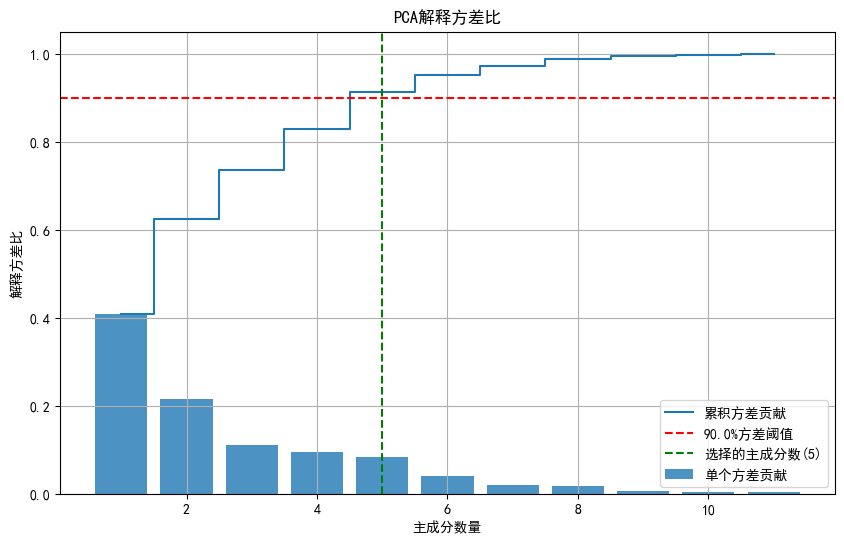

降维后的特征形状: (51714, 5)

主成分与原始特征的关系:
     Sum of amplitudes  Average instantaneous phase  Sum of energy  \
PC1          -0.176046                    -0.031813       0.412071   
PC2           0.551135                     0.009865       0.206711   
PC3           0.025106                     0.580434      -0.069728   
PC4          -0.097977                     0.595365       0.021861   
PC5           0.030720                     0.423768      -0.111074   

     Maximum amplitude  Minimum amplitude  Half energy   Most of  \
PC1           0.051577          -0.379610     0.045321 -0.345797   
PC2           0.562866           0.255613     0.289438  0.345334   
PC3          -0.245020           0.243581    -0.271577  0.245768   
PC4          -0.013259          -0.129607     0.726309 -0.202560   
PC5          -0.107490           0.049506    -0.225508  0.089911   

     Average energy  RMS amplitude  Average instantaneous frequency  \
PC1        0.410507       0.429856                        -0.025

In [5]:
# 对地震属性数据进行PCA降维
pca_results = perform_pca_analysis(
    data=data_H6_2_attr,
    attribute_columns=good_attributes,
    variance_threshold=0.9,
    output_dir=output_dir,
)

======== GMM聚类数评估开始 ========
聚类数量 1: BIC = 864181.36, AIC = 864004.29
聚类数量 2: BIC = 803853.86, AIC = 803490.87
聚类数量 3: BIC = 757203.48, AIC = 756654.56
聚类数量 4: BIC = 684601.27, AIC = 683866.43
聚类数量 5: BIC = 659216.80, AIC = 658296.04
聚类数量 6: BIC = 646843.70, AIC = 645737.02
聚类数量 7: BIC = 637027.48, AIC = 635734.87
聚类数量 8: BIC = 623205.99, AIC = 621727.46
聚类数量 9: BIC = 623334.13, AIC = 621669.68
聚类数量 10: BIC = 611202.54, AIC = 609352.16


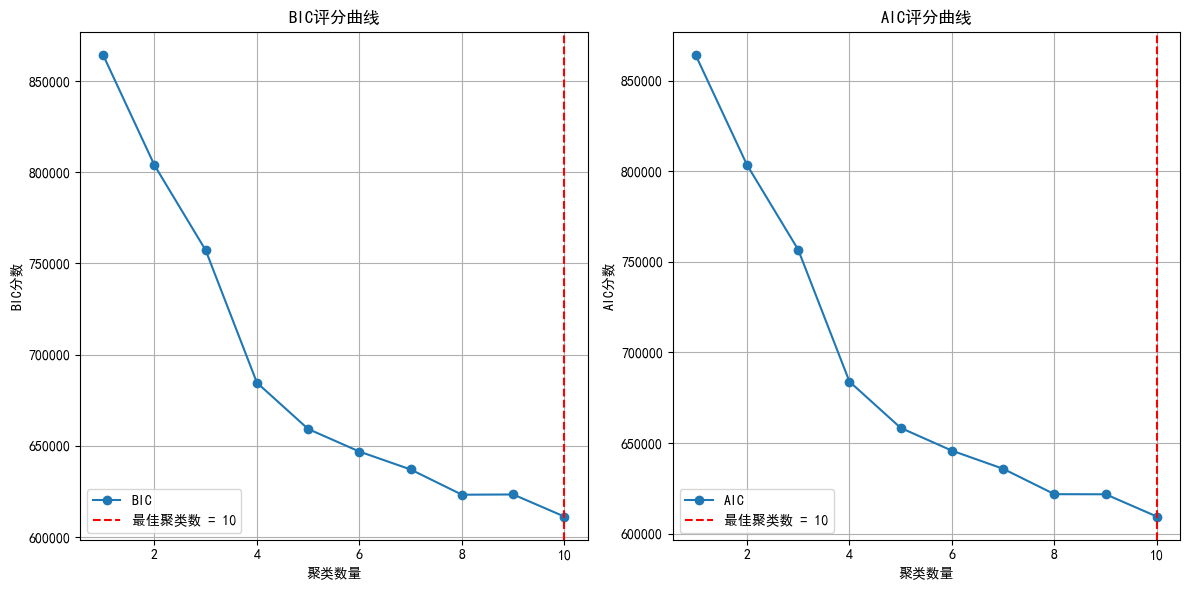

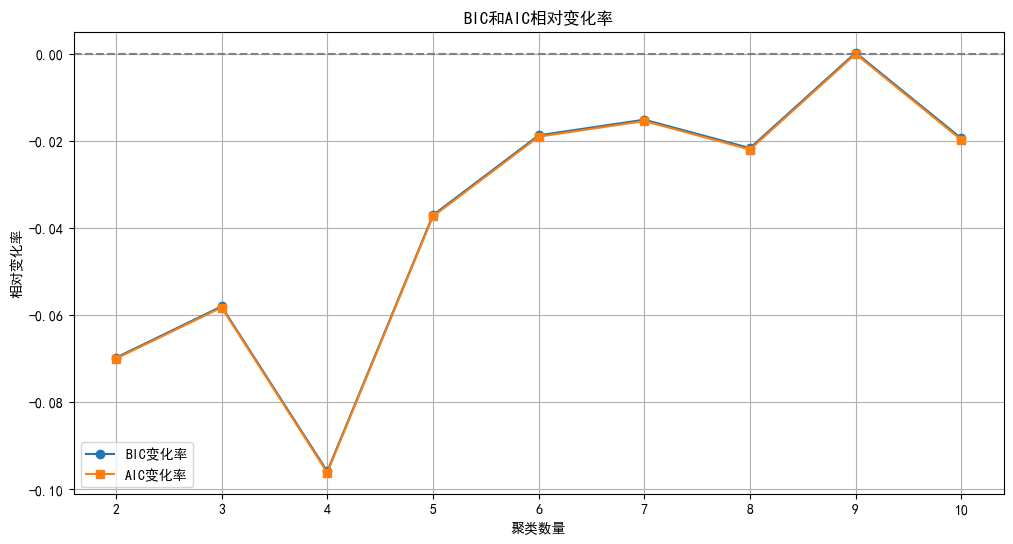

BIC变化率最大变化点: 聚类数 = 4
AIC变化率最大变化点: 聚类数 = 4

基于BIC的最佳聚类数: 10
基于AIC的最佳聚类数: 10
======== GMM聚类数评估完成 ========


In [7]:
# 首先评估最佳聚类数
gmm_evaluation = evaluate_gmm_clusters(features_pca=pca_results["features_pca"], max_clusters=10, output_dir=output_dir)

# 使用不同的聚类数执行GMM聚类
# 根据BIC/AIC结果选择的最佳聚类数
best_n = gmm_evaluation["best_n_components"]

======== 执行 4 聚类的GMM分析 ========


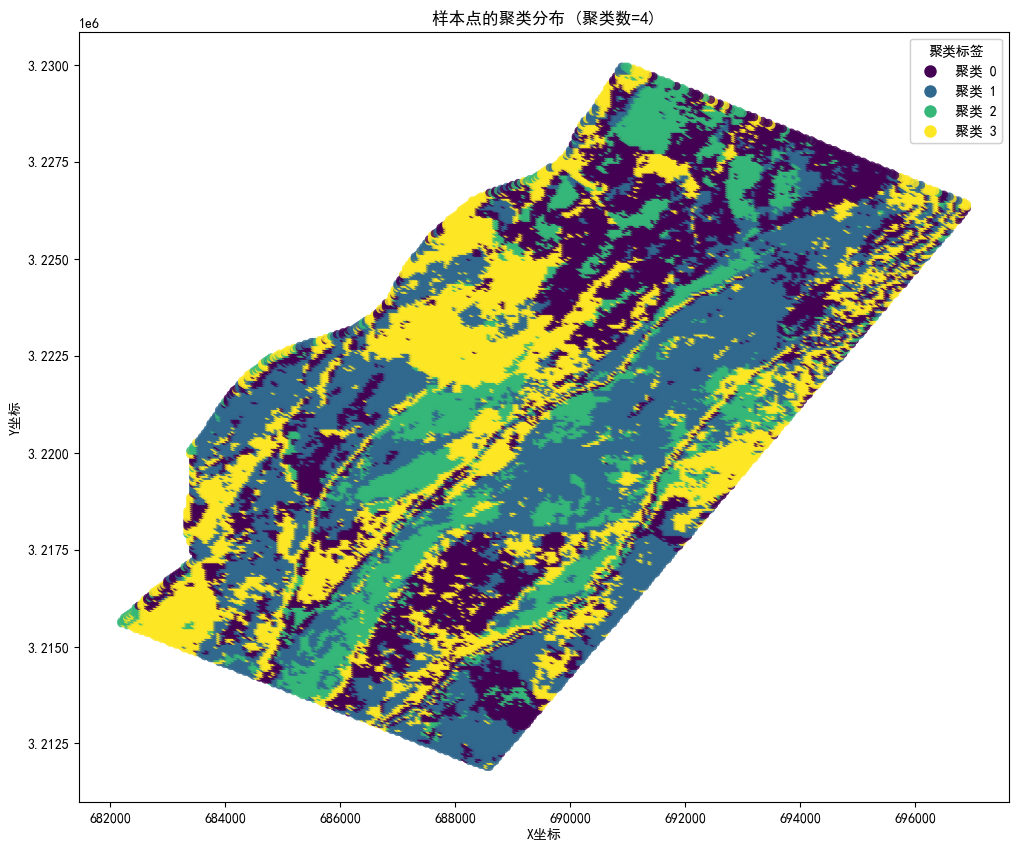

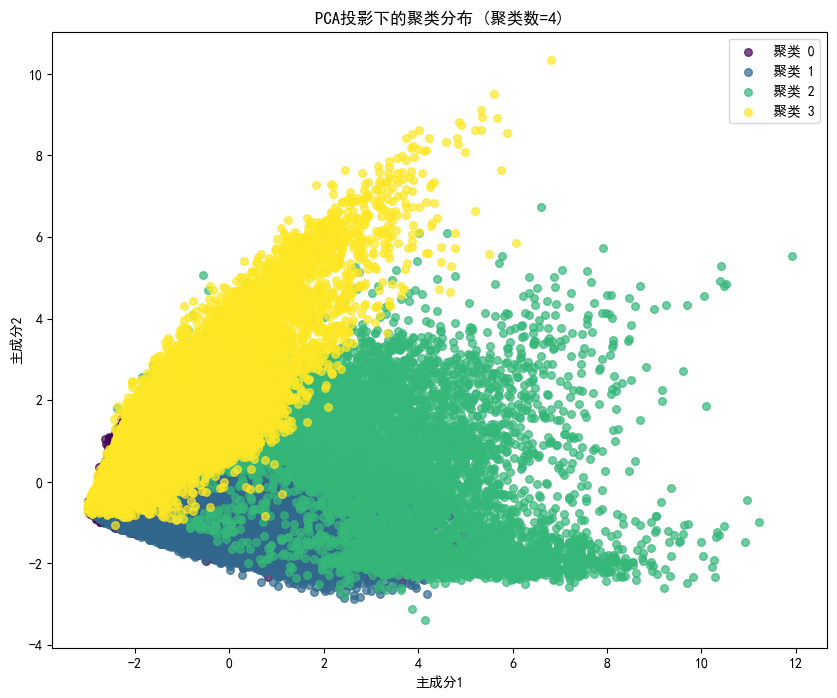

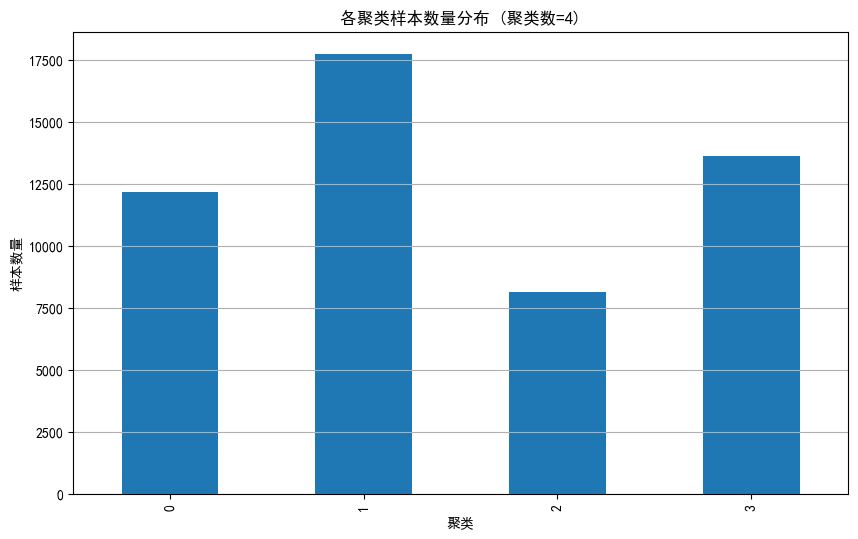


各聚类样本数量:
聚类 0: 12176 样本 (23.54%)
聚类 1: 17761 样本 (34.34%)
聚类 2: 8154 样本 (15.77%)
聚类 3: 13623 样本 (26.34%)
======== 4 聚类的GMM分析完成 ========


In [6]:
best_n = 4  # 如果需要，可以手动设置最佳聚类数

gmm_best = perform_gmm_clustering(
    features_pca=pca_results["features_pca"],
    coords=pca_results["coords_clean"],
    n_clusters=best_n,
    output_dir=output_dir,
)
gmm_best["result_df"].to_csv(os.path.join(output_dir, "gmm_best_clusters.csv"), index=False)

## GMM 中心混合扩充样本（于 PCA 空间）


使用 11 个属性列进行样本扩增
原始样本数: 30
目标扩增倍数: 2.0倍

各聚类样本数量:
聚类 0: 4 样本
聚类 1: 8 样本
聚类 2: 5 样本
聚类 3: 13 样本

聚类 0: 原始样本数 = 4, 目标样本数 = 8, 需要生成 4 个伪样本

聚类 1: 原始样本数 = 8, 目标样本数 = 16, 需要生成 8 个伪样本

聚类 2: 原始样本数 = 5, 目标样本数 = 10, 需要生成 5 个伪样本

聚类 3: 原始样本数 = 13, 目标样本数 = 26, 需要生成 13 个伪样本

扩增后的样本数: 60 (原始: 30, 合成: 30)
扩增比例: 2.00倍


c:\Users\OrekiMio\miniconda3\envs\attr_fusion_20250428\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


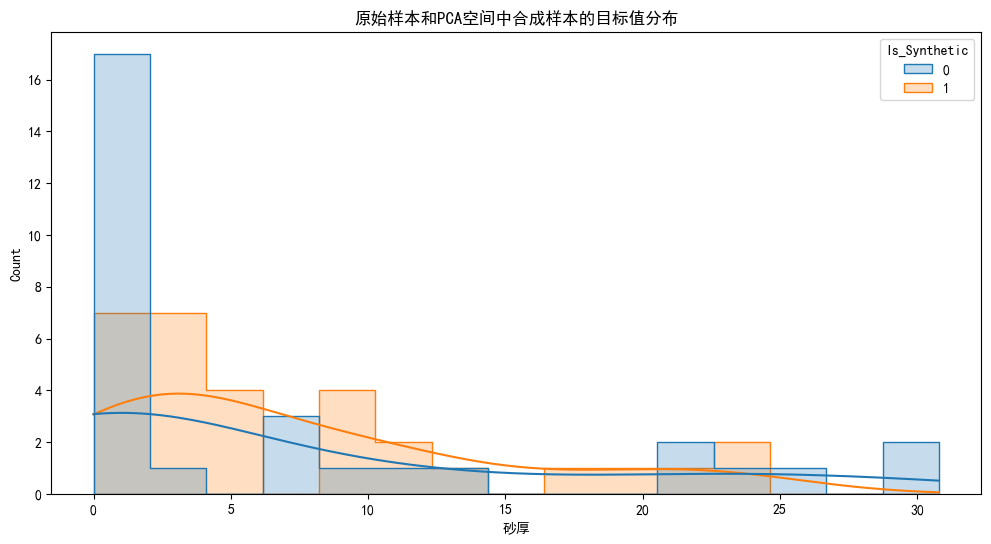

In [8]:
# 对井点数据进行PCA降维和GMM聚类
# 注意：这里使用pca_results中的PCA模型和标准化器，但我们需要重新应用到井点数据上

# 确定属性列 - 必须与PCA中使用的列完全一致
attribute_columns = pca_results["features_clean"].columns.tolist()

# 不要只提取特征列，而是保留所有需要的列
X_well = data_H6_2_well_selected.copy()

# 然后对特征列进行预处理
for col in attribute_columns:
    if pd.isna(X_well[col].mean()):
        print(f"列 '{col}' 的均值为NaN，使用0填充")
        X_well[col] = X_well[col].fillna(0)
    else:
        # 使用列均值填充
        X_well[col] = X_well[col].fillna(X_well[col].mean())

# 确保特征列没有剩余的NaN值
if X_well[attribute_columns].isna().any().any():
    print("警告：特征列中仍然存在NaN值，将它们替换为0")
    for col in attribute_columns:
        X_well[col] = X_well[col].fillna(0)

# 对井点数据进行标准化 - 只标准化特征列
X_well_scaled = pca_results["scaler"].transform(X_well[attribute_columns])

# 将井点数据投影到PCA空间
X_well_pca = pca_results["pca"].transform(X_well_scaled)

# 使用已有的GMM模型对井点数据进行聚类
cluster_labels_well = gmm_best["gmm"].predict(X_well_pca)
cluster_probs_well = gmm_best["gmm"].predict_proba(X_well_pca)

# 创建井点数据的聚类结果字典
well_cluster_results = {
    "cluster_labels": cluster_labels_well,
    "cluster_probs": cluster_probs_well,
}

# 使用PCA空间中的中心混合法生成伪样本
augmented_data = augment_samples_by_pca_mixing(
    well_data=X_well,
    pca_model=pca_results["pca"],
    scaler=pca_results["scaler"],
    cluster_results=well_cluster_results,
    attribute_columns=attribute_columns,
    target_column="Thickness of facies(1: Fine sand)",
    min_samples_per_cluster=4,  # 考虑井数据更少，设置更小的阈值
    augmentation_factor=2.0,  # 目标是原始样本数的2倍
    min_target_per_cluster=4,  # 每个聚类至少4个样本
    random_state=42,
    verbose=True,
)

# 保存扩增后的数据
augmented_data.to_csv(os.path.join(output_dir, "augmented_well_data_pca.csv"), index=False)

# 可视化目标值分布
plt.figure(figsize=(12, 6))
sns.histplot(
    data=augmented_data,
    x="Thickness of facies(1: Fine sand)",
    hue="Is_Synthetic",
    element="step",
    bins=15,
    kde=True,
)
plt.title("原始样本和PCA空间中合成样本的目标值分布")
plt.xlabel("砂厚")
plt.savefig(
    os.path.join(output_dir, "pca_augmented_samples_target_dist.png"),
    dpi=300,
    bbox_inches="tight",
)
plt.show()

## 数据整理


### 1. 未扩充的原始井点数据 + One-Hot 编码 + 聚类概率


In [9]:
# 复制原始井点数据
original_well_data = X_well.copy()

# 添加聚类标签
original_well_data["Cluster"] = cluster_labels_well

# 添加聚类概率
original_well_data["cluster_probs"] = list(cluster_probs_well)

# 应用One-Hot编码
original_well_data_encoded = encode_cluster_features(
    data=original_well_data,
    cluster_column="Cluster",
    drop_original=False,
    prefix="Cluster_",
)

# 保存处理后的数据
output_file = os.path.join(output_dir, "original_well_data_with_clusters.csv")
original_well_data_encoded.to_csv(output_file, index=False)

print(f"原始井点数据（带聚类特征）已保存至: {output_file}")
print(f"数据形状: {original_well_data_encoded.shape}")
print(f"包含的特征列数量: {len(original_well_data_encoded.columns)}")

对'Cluster'列进行One-Hot编码，发现4个唯一的聚类标签
One-Hot编码后数据形状: (30, 27)，新增了4个特征列
编码后的特征列: Cluster__0, Cluster__1, Cluster__2, Cluster__3
原始井点数据（带聚类特征）已保存至: output\original_well_data_with_clusters.csv
数据形状: (30, 27)
包含的特征列数量: 27


### 2. 扩充后的数据 + One-Hot 编码


In [10]:
augmented_well_data_encoded = encode_cluster_features(
    data=augmented_data,
    cluster_column="Cluster",
    drop_original=False,
    prefix="Cluster_",
)

print("\n原始和扩充后井点数据对比:")
print(f"  - 原始井点数据: {len(original_well_data_encoded)} 行")
print(f"  - 扩充后数据: {len(augmented_well_data_encoded)} 行")

对'Cluster'列进行One-Hot编码，发现4个唯一的聚类标签
One-Hot编码后数据形状: (60, 27)，新增了4个特征列
编码后的特征列: Cluster__0, Cluster__1, Cluster__2, Cluster__3

原始和扩充后井点数据对比:
  - 原始井点数据: 30 行
  - 扩充后数据: 60 行


### 3. 全体地震数据 + One-Hot 编码 + 聚类概率


In [11]:
# 直接使用gmm_best["result_df"]，它已经包含了坐标和聚类标签
seismic_with_clusters = gmm_best["result_df"].copy()

# 添加聚类概率
seismic_with_clusters["cluster_probs"] = list(gmm_best["cluster_probs"])

# 将result_df与原始地震数据合并，以保留所有地震属性
# 首先确保坐标列的名称一致
coords_columns = ["X", "Y", "Z"]

# 将地震属性合并到聚类结果中
# 通过坐标列进行合并，这应该是一对一的匹配
seismic_data_full = pd.merge(seismic_with_clusters, data_H6_2_attr, on=coords_columns, how="left")

# 应用One-Hot编码
seismic_data_encoded = encode_cluster_features(
    data=seismic_data_full,
    cluster_column="Cluster",
    drop_original=False,
    prefix="Cluster_",
)

# 保存处理后的数据
output_file = os.path.join(output_dir, "seismic_data_with_clusters.csv")
seismic_data_encoded.to_csv(output_file, index=False)

print(f"全体地震数据（带聚类特征）已保存至: {output_file}")
print(f"数据形状: {seismic_data_encoded.shape}")
print(f"包含的特征列数量: {len(seismic_data_encoded.columns)}")

对'Cluster'列进行One-Hot编码，发现4个唯一的聚类标签
One-Hot编码后数据形状: (51714, 26)，新增了4个特征列
编码后的特征列: Cluster__0, Cluster__1, Cluster__2, Cluster__3
全体地震数据（带聚类特征）已保存至: output\seismic_data_with_clusters.csv
数据形状: (51714, 26)
包含的特征列数量: 26


In [12]:
print("\n============ 数据整理完成 ============")

# 展示所有准备好的数据集的前几行
print("\n原始井点数据（带聚类特征）前5行:")
display(original_well_data_encoded.head())

print("\n扩充后井点数据（带聚类特征）前5行:")
display(augmented_well_data_encoded.head())

print("\n全体地震数据（带聚类特征）前5行:")
display(seismic_data_encoded.head())


============ 数据整理完成 ============

原始井点数据（带聚类特征）前5行:


X          Y       Z Surface Well  \
0  686325.6  3217019.1 -2649.7    H6-2   A1   
1  686616.5  3217415.2 -2633.0    H6-2  A10   
2  686278.0  3217627.9 -2650.4    H6-2  A11   
3  686149.5  3216665.5 -2642.5    H6-2   A2   
4  685921.1  3216986.2 -2644.7    H6-2   A4   

   Thickness of facies(1: Fine sand)  facies(1: Fine sand)  Average energy  \
0                               0.00                  0.00      89001976.0   
1                               7.87                 45.82      76951152.0   
2                               0.00                  0.00       6199530.0   
3                               0.75                  5.16      88260688.0   
4                               0.00                  0.00      31338386.0   

   Average envelope  Average instantaneous frequency  ...  Most of  \
0           11011.2                             21.9  ... -13431.1   
1           11667.5                             25.9  ... -13626.4   
2            2127.4                             49.7  ...   -556.0   
3           12334.4                             21.0  ... -14014.2   
4            5349.9                             25.9  ...   4900.9   

   RMS amplitude  Sum of amplitudes  Sum of energy  Cluster  \
0         9511.8           -66162.7      718160960        1   
1         8764.0           -36986.6      724726848        1   
2         2459.4             2576.6       26151754        3   
3         9393.7           -57804.2      667979712        1   
4         5553.1            15000.3       97357456        3   

                                       cluster_probs  Cluster__0  Cluster__1  \
0  [6.420945233062633e-93, 0.8824988613202626, 0....       False        True   
1  [2.086436764912327e-64, 0.9158616465493805, 0....       False        True   
2  [7.376262894816395e-17, 0.06562405275944784, 3...       False       False   
3  [1.4653241111432104e-82, 0.9644475479936692, 0...       False        True   
4  [7.131718947933407e-07, 3.7348311957461486e-15...       False       False   

   Cluster__2  Cluster__3  
0       False       False  
1       False       False  
2       False        True  
3       False       False  
4       False        True  

[5 rows x 27 columns]


扩充后井点数据（带聚类特征）前5行:


X          Y       Z Surface Well  \
0  686325.6  3217019.1 -2649.7    H6-2   A1   
1  686616.5  3217415.2 -2633.0    H6-2  A10   
2  686278.0  3217627.9 -2650.4    H6-2  A11   
3  686149.5  3216665.5 -2642.5    H6-2   A2   
4  685921.1  3216986.2 -2644.7    H6-2   A4   

   Thickness of facies(1: Fine sand)  facies(1: Fine sand)  Average energy  \
0                               0.00                  0.00      89001976.0   
1                               7.87                 45.82      76951152.0   
2                               0.00                  0.00       6199530.0   
3                               0.75                  5.16      88260688.0   
4                               0.00                  0.00      31338386.0   

   Average envelope  Average instantaneous frequency  ...  Most of  \
0           11011.2                             21.9  ... -13431.1   
1           11667.5                             25.9  ... -13626.4   
2            2127.4                             49.7  ...   -556.0   
3           12334.4                             21.0  ... -14014.2   
4            5349.9                             25.9  ...   4900.9   

   RMS amplitude  Sum of amplitudes  Sum of energy  Cluster  Is_Synthetic  \
0         9511.8           -66162.7    718160960.0        1             0   
1         8764.0           -36986.6    724726848.0        1             0   
2         2459.4             2576.6     26151754.0        3             0   
3         9393.7           -57804.2    667979712.0        1             0   
4         5553.1            15000.3     97357456.0        3             0   

   Cluster__0  Cluster__1  Cluster__2  Cluster__3  
0       False        True       False       False  
1       False        True       False       False  
2       False       False       False        True  
3       False        True       False       False  
4       False       False       False        True  

[5 rows x 27 columns]


全体地震数据（带聚类特征）前5行:


X             Y            Z  Cluster  \
0  688546.288809  3.211900e+06 -2472.896240        1   
1  688596.288809  3.211900e+06 -2475.649902        1   
2  688446.288809  3.211950e+06 -2465.910889        1   
3  688496.288809  3.211950e+06 -2469.487061        1   
4  688546.288809  3.211950e+06 -2472.695801        3   

                                       cluster_probs  column  row  \
0  [7.0195686798430535e-28, 0.9980805354507352, 0...   128.0  1.0   
1  [6.01922781118644e-39, 0.9997551553922595, 0.0...   129.0  1.0   
2  [4.3045032098247844e-42, 0.9988770325075547, 0...   126.0  2.0   
3  [2.1957930474947042e-28, 0.9961415881393277, 0...   127.0  2.0   
4  [8.124192009580613e-16, 0.0006240801669347535,...   128.0  2.0   

   Average energy  Average envelope  Average instantaneous frequency  ...  \
0      3538352.25       3114.544678                        32.982338  ...   
1      6365790.00       3344.748779                        33.155682  ...   
2      9748781.00       4269.621094                        35.096291  ...   
3      5062806.00       3648.766113                        31.971563  ...   
4      2440221.75       2865.032471                        31.293999  ...   

   Mean amplitude  Minimum amplitude      Most of  RMS amplitude  \
0        2.929171       -4733.179688 -1407.374023    1881.050903   
1     -694.975952       -6009.879395 -3890.315186    2523.051758   
2    -1966.760742       -4311.731445 -4174.034180    3122.303711   
3     -305.388153       -3698.805908 -2776.277588    2250.067871   
4      259.224304       -3199.861816  -804.671692    1562.120972   

   Sum of amplitudes  Sum of energy  Cluster__0  Cluster__1  Cluster__2  \
0          20.173805     24369364.0       False        True       False   
1       -5150.304688     47175384.0       False        True       False   
2      -12580.833984     62360304.0       False        True       False   
3       -1948.564331     32303816.0       False        True       False   
4        1674.420532     15762248.0       False       False       False   

   Cluster__3  
0       False  
1       False  
2       False  
3       False  
4        True  

[5 rows x 26 columns]

## 属性间相关性分析 + RF importance（SVR）


======== 属性相关性分析开始 (方法: pearson) ========
属性数量: 11


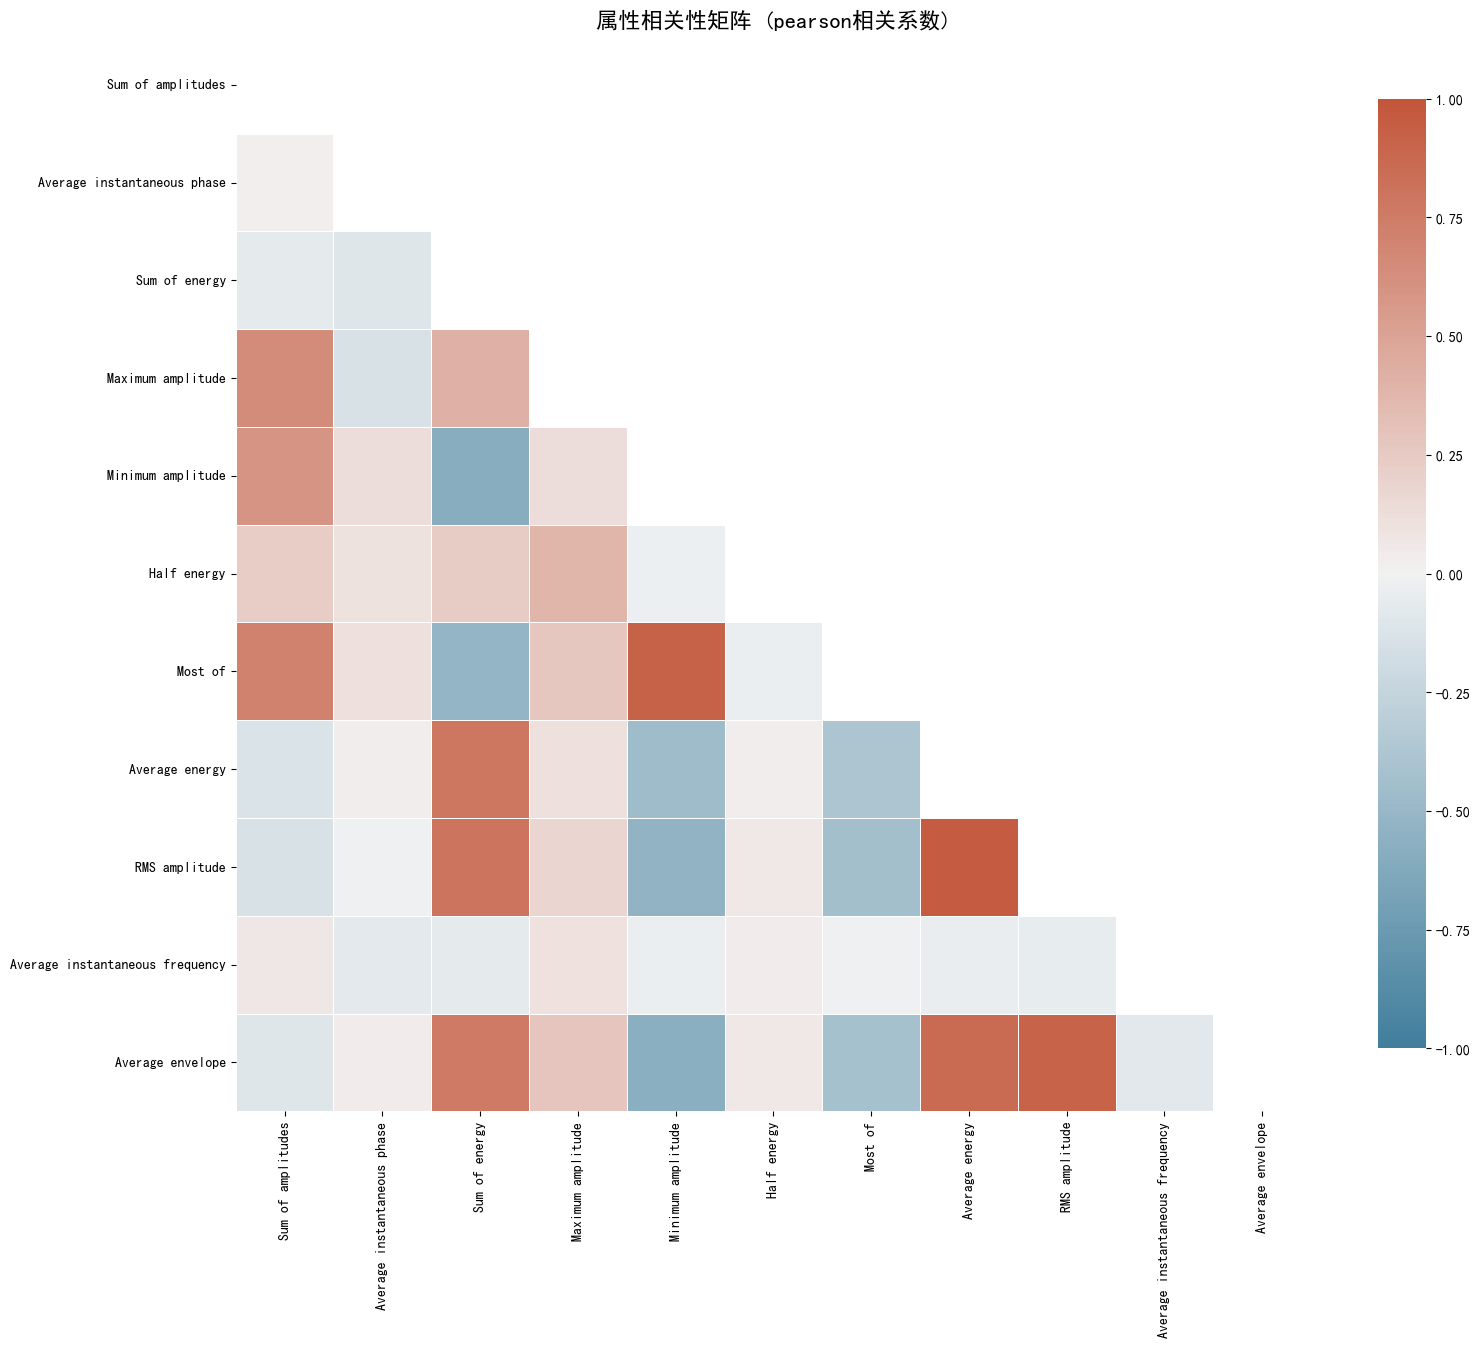


高度相关的属性组 (相关系数阈值 >= 0.85):

组 1 (包含 2 个属性):
  - Minimum amplitude
  - Most of

组 2 (包含 3 个属性):
  - Average envelope
  - RMS amplitude
  - Average energy

独立属性 (6 个):
  - Sum of amplitudes
  - Average instantaneous phase
  - Sum of energy
  - Maximum amplitude
  - Half energy
  - Average instantaneous frequency

各组内部平均相关系数:
  - 组 1: 0.9198
  - 组 2: 0.9084
======== 属性相关性分析完成 ========

相关属性组统计:
  - 总组数: 8
  - 最大组大小: 3 属性
  - 包含多个属性的组数: 2
  - 平均组大小: 1.38 属性


In [13]:
# 分析原始特征的相关性
correlated_attribute_groups = analyze_attribute_correlations(
    features_df=pca_results["features_clean"],  # 使用PCA结果中的清理后特征
    method="pearson",  # 使用Pearson相关系数
    corr_threshold=0.85,  # 相关性阈值设为0.85
    output_dir=output_dir,  # 输出目录
    figsize=(16, 14),  # 图像尺寸
)

# 输出每个组的特征数量统计
group_sizes = [len(group) for group in correlated_attribute_groups]
print(f"\n相关属性组统计:")
print(f"  - 总组数: {len(correlated_attribute_groups)}")
print(f"  - 最大组大小: {max(group_sizes)} 属性")
print(f"  - 包含多个属性的组数: {sum(1 for size in group_sizes if size > 1)}")
print(f"  - 平均组大小: {sum(group_sizes) / len(group_sizes):.2f} 属性")

======== 按组进行随机森林特征重要性分析 ========

组 1 只有一个属性: Sum of amplitudes，直接添加到选择列表

组 2 只有一个属性: Average instantaneous phase，直接添加到选择列表

组 3 只有一个属性: Sum of energy，直接添加到选择列表

组 4 只有一个属性: Maximum amplitude，直接添加到选择列表

分析组 5 (包含 2 个属性):
  - Minimum amplitude
  - Most of
  组 5 模型性能: MSE = 160.2294, R² = -0.3866
  组 5 特征重要性:
    - Minimum amplitude: 0.654043
    - Most of: 0.345957
  从组 5 中选择的特征: Minimum amplitude


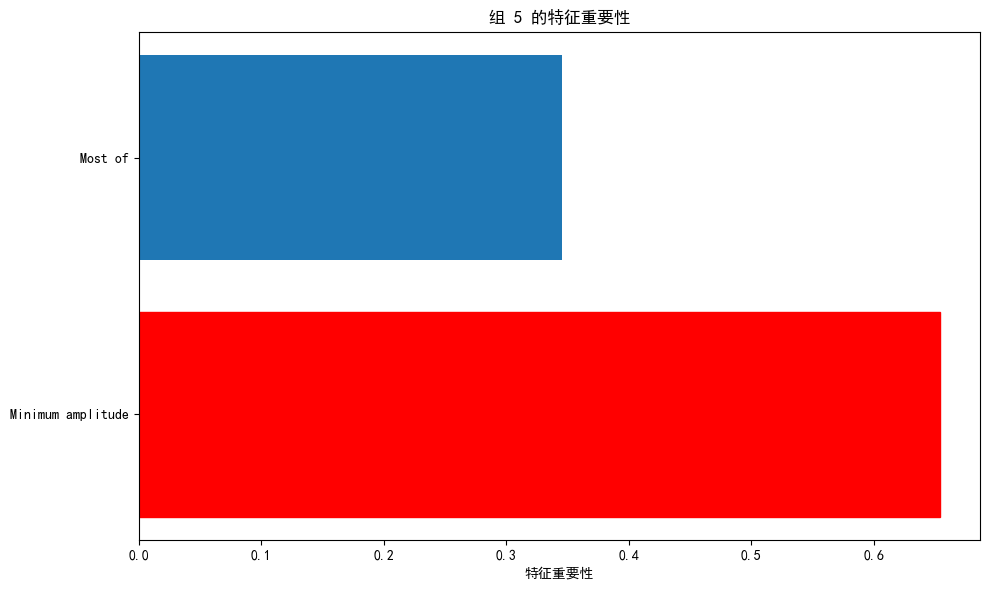


组 6 只有一个属性: Half energy，直接添加到选择列表

分析组 7 (包含 3 个属性):
  - Average envelope
  - RMS amplitude
  - Average energy
  组 7 模型性能: MSE = 207.4919, R² = -0.7956
  组 7 特征重要性:
    - RMS amplitude: 0.394811
    - Average energy: 0.314552
    - Average envelope: 0.290638
  从组 7 中选择的特征: RMS amplitude


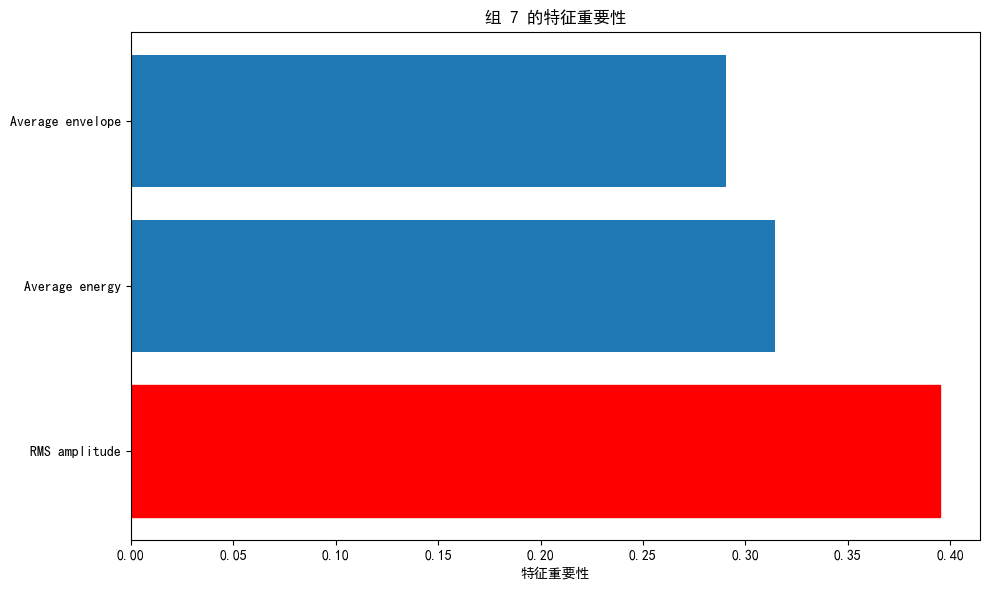


组 8 只有一个属性: Average instantaneous frequency，直接添加到选择列表


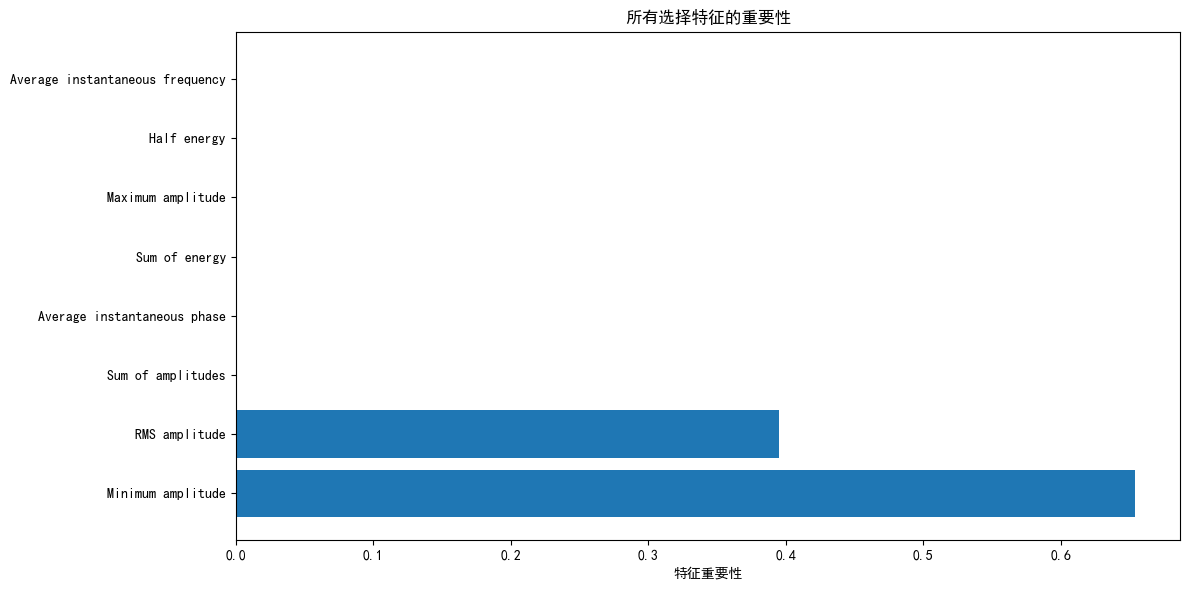


最终选择的特征列表:
1. Minimum amplitude: 0.654043
2. RMS amplitude: 0.394811
3. Sum of amplitudes: 0.000000
4. Average instantaneous phase: 0.000000
5. Sum of energy: 0.000000
6. Maximum amplitude: 0.000000
7. Half energy: 0.000000
8. Average instantaneous frequency: 0.000000

共选择了 8 个特征用于建模
======== 随机森林特征重要性分析完成 ========


In [14]:
# 在井点数据上应用随机森林重要性分析
# 使用原始井点数据，不使用扩增数据
selected_features = analyze_rf_importance_by_group(
    well_data=data_H6_2_well_selected,  # 原始井点数据
    attribute_groups=correlated_attribute_groups,  # 前面生成的属性组
    target_column="Thickness of facies(1: Fine sand)",
    top_n=1,  # 每组选择1个最重要的特征
    test_size=0.3,
    n_estimators=100,
    random_state=42,
    output_dir=output_dir,
    verbose=True,
)

## SVR


======== SVR回归建模开始 ========
使用数据集大小: 30 行
训练集大小: 21 样本
测试集大小: 9 样本
训练集中砂厚为0的样本比例: 42.86%
测试集中砂厚为0的样本比例: 44.44%
使用特征数量: 8

正在训练SVR模型并优化参数...
Fitting 5 folds for each of 192 candidates, totalling 960 fits

最佳SVR参数:
  - C: 100
  - epsilon: 0.5
  - gamma: auto
  - kernel: poly

模型评估指标:
  - R²: -1.0620
  - MAE: 12.5271
  - RMSE: 15.5943

砂厚判别能力 (阈值 = 0.1):
  - 总体准确率: 0.4444
  - 真实为0时预测为0的比例: 0.2500
  - 真实不为0时预测不为0的比例: 0.6000


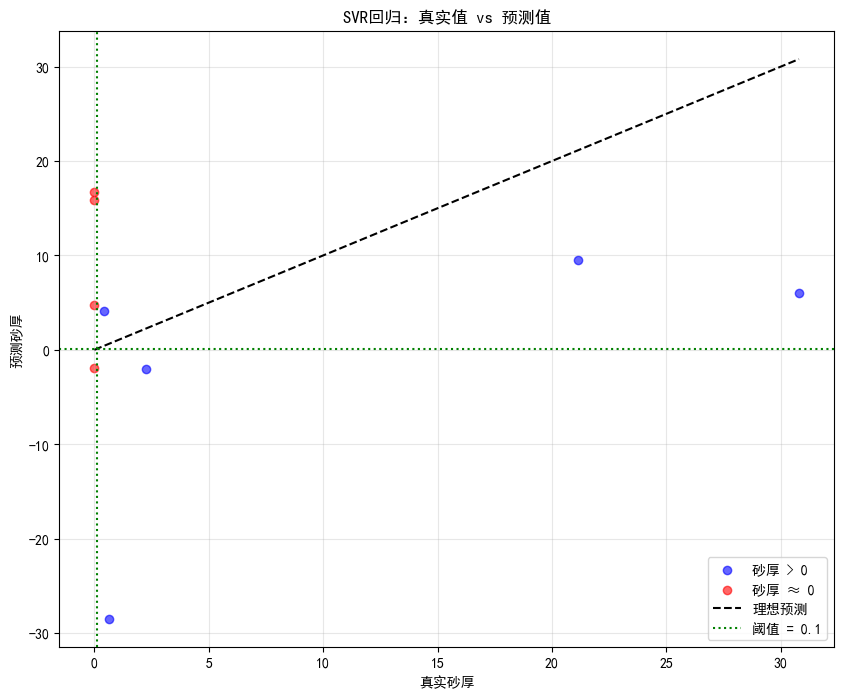

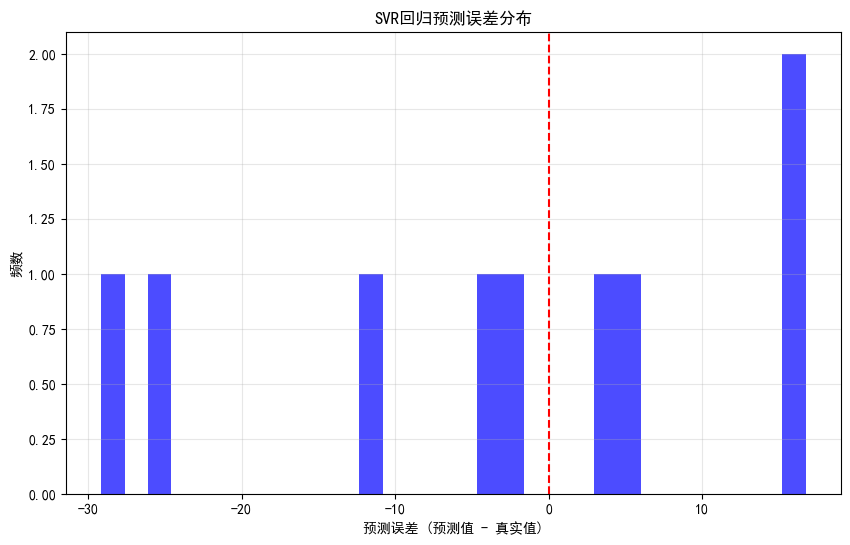

======== SVR回归建模完成 ========
======== SVR回归建模开始 ========
使用数据集大小: 30 行
添加4个One-Hot编码的聚类特征
训练集大小: 21 样本
测试集大小: 9 样本
训练集中砂厚为0的样本比例: 42.86%
测试集中砂厚为0的样本比例: 44.44%
使用特征数量: 12

正在训练SVR模型并优化参数...
Fitting 5 folds for each of 192 candidates, totalling 960 fits

最佳SVR参数:
  - C: 100
  - epsilon: 0.01
  - gamma: auto
  - kernel: poly

模型评估指标:
  - R²: -0.7244
  - MAE: 10.9312
  - RMSE: 14.2604

砂厚判别能力 (阈值 = 0.1):
  - 总体准确率: 0.3333
  - 真实为0时预测为0的比例: 0.2500
  - 真实不为0时预测不为0的比例: 0.4000


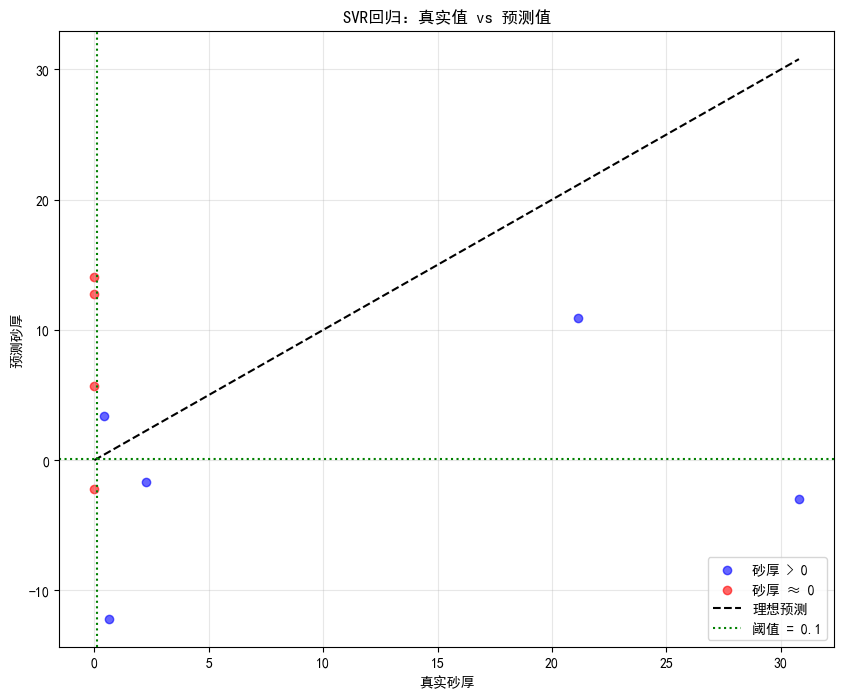

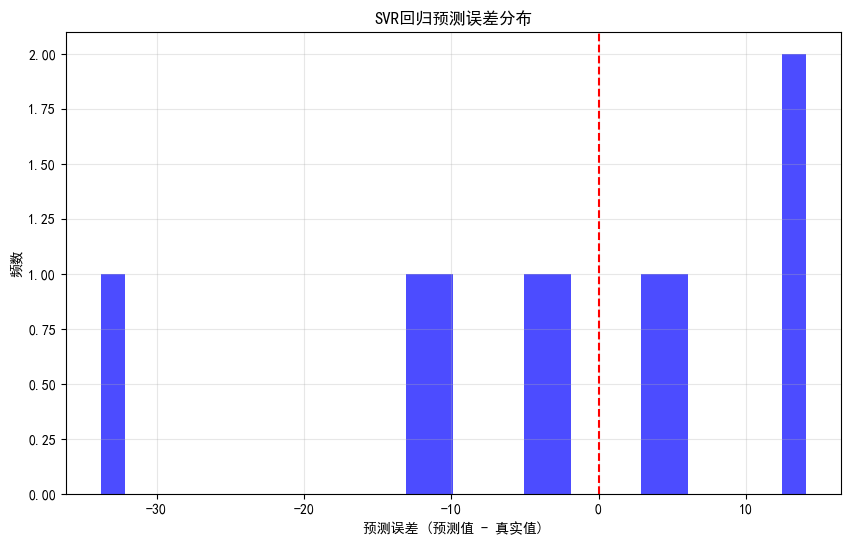

======== SVR回归建模完成 ========
======== SVR回归建模开始 ========
使用数据集大小: 60 行
训练集大小: 42 样本
测试集大小: 18 样本
训练集中砂厚为0的样本比例: 26.19%
测试集中砂厚为0的样本比例: 22.22%
使用特征数量: 8

正在训练SVR模型并优化参数...
Fitting 5 folds for each of 192 candidates, totalling 960 fits

最佳SVR参数:
  - C: 10
  - epsilon: 0.01
  - gamma: scale
  - kernel: linear

模型评估指标:
  - R²: 0.4438
  - MAE: 4.1179
  - RMSE: 6.6441

砂厚判别能力 (阈值 = 0.1):
  - 总体准确率: 0.7222
  - 真实为0时预测为0的比例: 0.0000
  - 真实不为0时预测不为0的比例: 0.9286


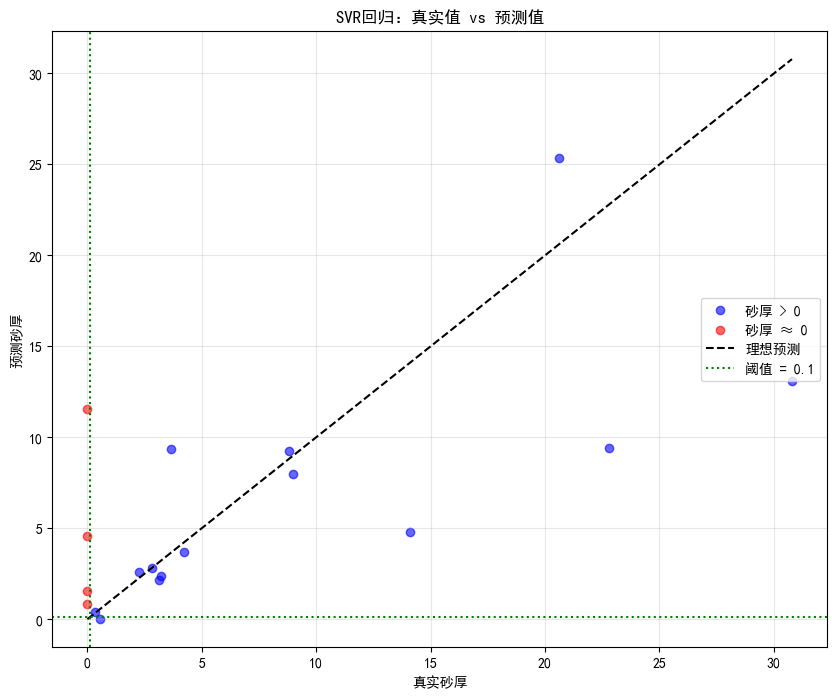

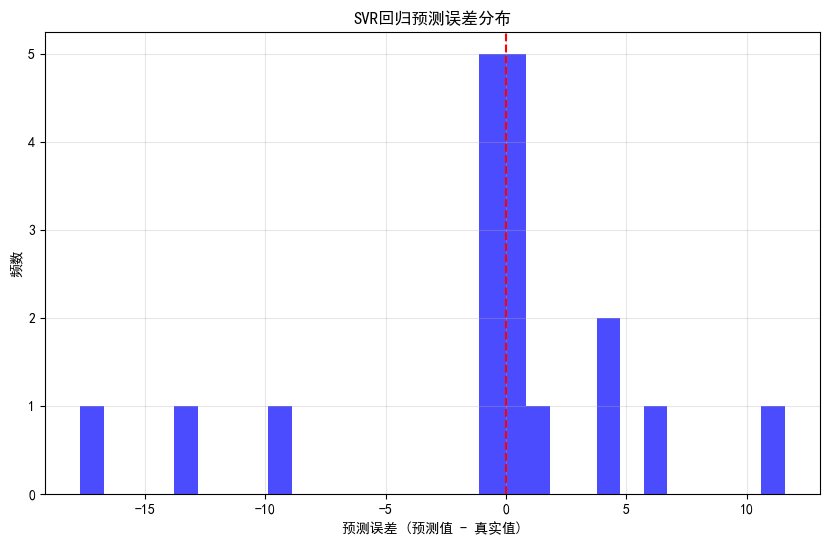

======== SVR回归建模完成 ========
======== SVR回归建模开始 ========
使用数据集大小: 60 行
添加4个One-Hot编码的聚类特征
训练集大小: 42 样本
测试集大小: 18 样本
训练集中砂厚为0的样本比例: 26.19%
测试集中砂厚为0的样本比例: 22.22%
使用特征数量: 12

正在训练SVR模型并优化参数...
Fitting 5 folds for each of 192 candidates, totalling 960 fits

最佳SVR参数:
  - C: 100
  - epsilon: 0.5
  - gamma: 0.1
  - kernel: rbf

模型评估指标:
  - R²: 0.6621
  - MAE: 3.8462
  - RMSE: 5.1788

砂厚判别能力 (阈值 = 0.1):
  - 总体准确率: 0.8333
  - 真实为0时预测为0的比例: 0.2500
  - 真实不为0时预测不为0的比例: 1.0000


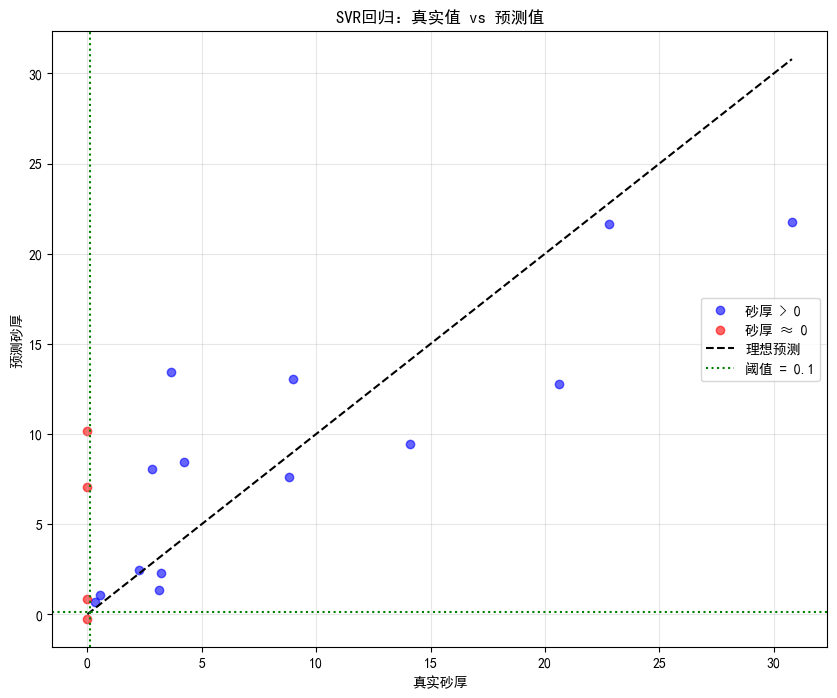

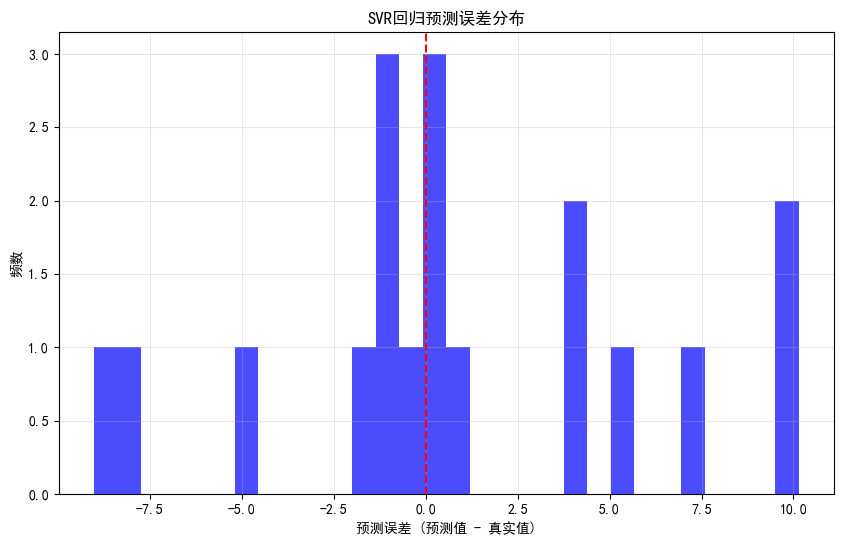

======== SVR回归建模完成 ========

SVR模型性能比较:


模型类型  样本数  特征数        R²       RMSE  真实为0预测正确率  真实非0预测正确率
0       原始数据   30    8 -1.062010  15.594260       0.25   0.600000
1  原始数据+模式识别   30   12 -0.724356  14.260439       0.25   0.400000
2       扩容数据   60    8  0.443768   6.644091       0.00   0.928571
3  扩容数据+模式识别   60   12  0.662051   5.178846       0.25   1.000000

In [15]:
# 创建模型比较输出目录
model_comparison_dir = "svr_models_comparison"
if not os.path.exists(model_comparison_dir):
    os.makedirs(model_comparison_dir)

# 1. 原始数据 + selected_features + cluster_probs
svr_original_probs = build_svr_model(
    data=original_well_data_encoded,
    selected_features=selected_features,
    target_column="Thickness of facies(1: Fine sand)",
    use_cluster_probs=False,
    use_onehot=False,
    output_dir=model_comparison_dir,
    filename_prefix="original_with_probs",
)

# 2. 原始数据 + selected_features + one-hot
svr_original_onehot = build_svr_model(
    data=original_well_data_encoded,
    selected_features=selected_features,
    target_column="Thickness of facies(1: Fine sand)",
    use_cluster_probs=False,
    use_onehot=True,
    output_dir=model_comparison_dir,
    filename_prefix="original_with_onehot",
)

# 3. 扩容数据 + selected_features
svr_augmented_base = build_svr_model(
    data=augmented_well_data_encoded,
    selected_features=selected_features,
    target_column="Thickness of facies(1: Fine sand)",
    use_cluster_probs=False,
    use_onehot=False,
    output_dir=model_comparison_dir,
    filename_prefix="augmented_base",
)

# 4. 扩容数据 + selected_features + one-hot
svr_augmented_onehot = build_svr_model(
    data=augmented_well_data_encoded,
    selected_features=selected_features,
    target_column="Thickness of facies(1: Fine sand)",
    use_cluster_probs=False,
    use_onehot=True,
    output_dir=model_comparison_dir,
    filename_prefix="augmented_with_onehot",
)

# 创建模型比较结果表
models = [
    {"name": "原始数据", "results": svr_original_probs},
    {"name": "原始数据+模式识别", "results": svr_original_onehot},
    {"name": "扩容数据", "results": svr_augmented_base},
    {"name": "扩容数据+模式识别", "results": svr_augmented_onehot},
]

# 创建模型比较表
comparison_data = []
for model in models:
    comparison_data.append(
        {
            "模型类型": model["name"],
            "样本数": model["results"]["config"]["data_size"],
            "特征数": model["results"]["config"]["total_features"],
            "R²": model["results"]["metrics"]["r2"],
            "RMSE": model["results"]["metrics"]["rmse"],
            "真实为0预测正确率": model["results"]["metrics"]["true_negative_rate"],
            "真实非0预测正确率": model["results"]["metrics"]["true_positive_rate"],
        }
    )

comparison_df = pd.DataFrame(comparison_data)
comparison_df.to_csv(os.path.join(model_comparison_dir, "svr_models_comparison.csv"), index=False)
print("\nSVR模型性能比较:")
display(comparison_df)


======== 使用所有模型进行全区域预测 ========

==== 使用原始数据模型进行预测 ====
模型R²: -1.0620
======== 开始预测砂厚 ========
数据点数: 51714
使用模型预测51714个点的砂厚...
有14552个点的预测砂厚为负值，已将其置为0

预测结果统计:
  - 总点数: 51714
  - 预测砂厚≤0.1的点数: 14687 (28.40%)
  - 预测砂厚>0.1的点数: 37027 (71.60%)
  - 平均预测砂厚: 6.5964
  - 最大预测砂厚: 418.9887

预测结果已保存到文件: svr_models_comparison\model_原始数据_sand_thickness.csv


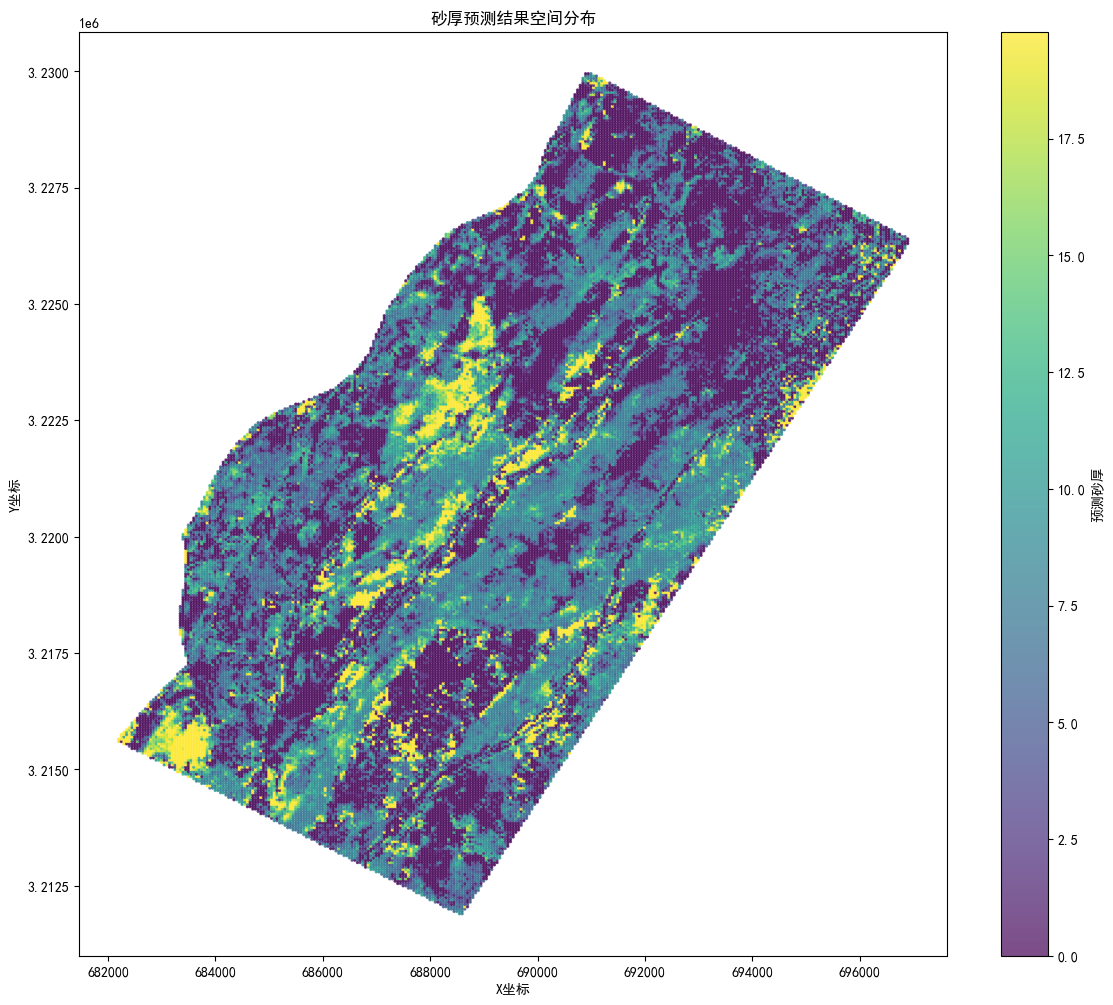

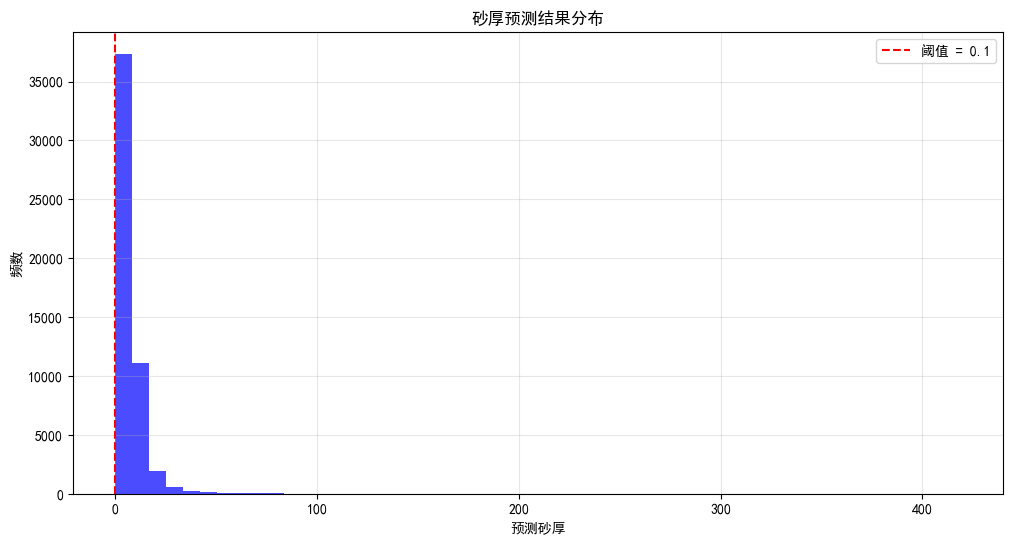

预测结果已保存为Petrel可导入的XYZ格式: svr_models_comparison\model_原始数据_sand_thickness_petrel.txt
======== 砂厚预测完成 ========

==== 使用原始数据+模式识别模型进行预测 ====
模型R²: -0.7244
======== 开始预测砂厚 ========
数据点数: 51714
使用模型预测51714个点的砂厚...
有15238个点的预测砂厚为负值，已将其置为0

预测结果统计:
  - 总点数: 51714
  - 预测砂厚≤0.1的点数: 15484 (29.94%)
  - 预测砂厚>0.1的点数: 36230 (70.06%)
  - 平均预测砂厚: 5.2885
  - 最大预测砂厚: 129.1804

预测结果已保存到文件: svr_models_comparison\model_原始数据_模式识别_sand_thickness.csv


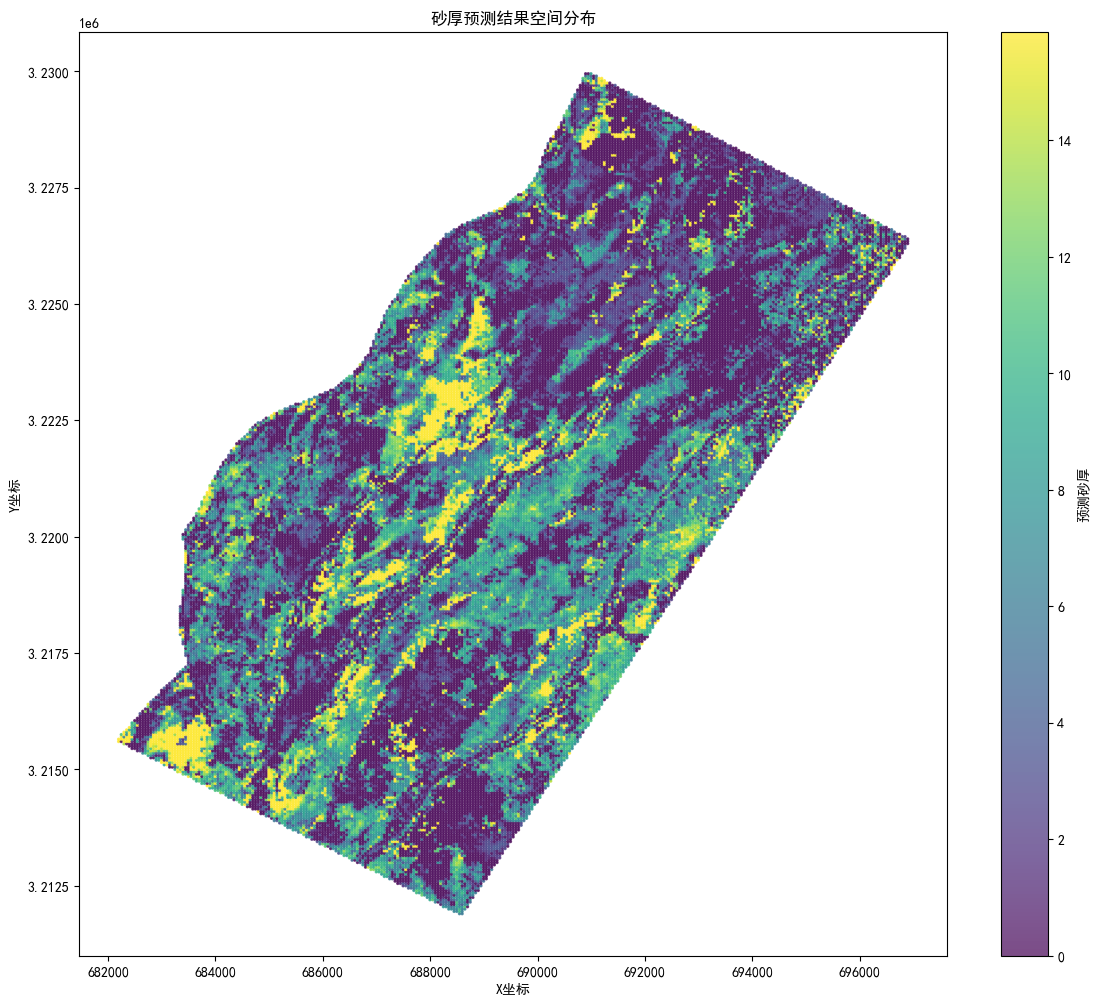

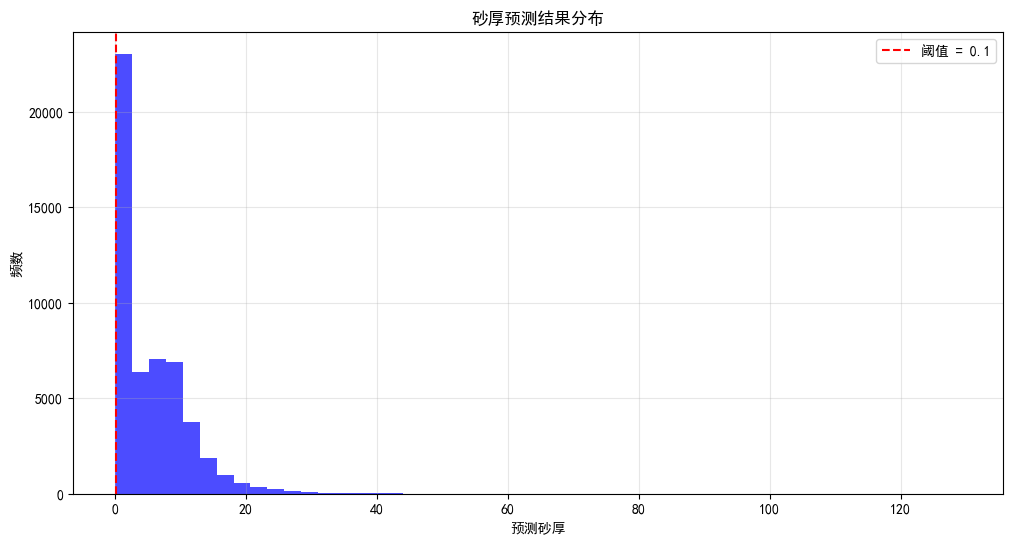

预测结果已保存为Petrel可导入的XYZ格式: svr_models_comparison\model_原始数据_模式识别_sand_thickness_petrel.txt
======== 砂厚预测完成 ========

==== 使用扩容数据模型进行预测 ====
模型R²: 0.4438
======== 开始预测砂厚 ========
数据点数: 51714
使用模型预测51714个点的砂厚...
有13003个点的预测砂厚为负值，已将其置为0

预测结果统计:
  - 总点数: 51714
  - 预测砂厚≤0.1的点数: 13191 (25.51%)
  - 预测砂厚>0.1的点数: 38523 (74.49%)
  - 平均预测砂厚: 5.3944
  - 最大预测砂厚: 34.2291

预测结果已保存到文件: svr_models_comparison\model_扩容数据_sand_thickness.csv


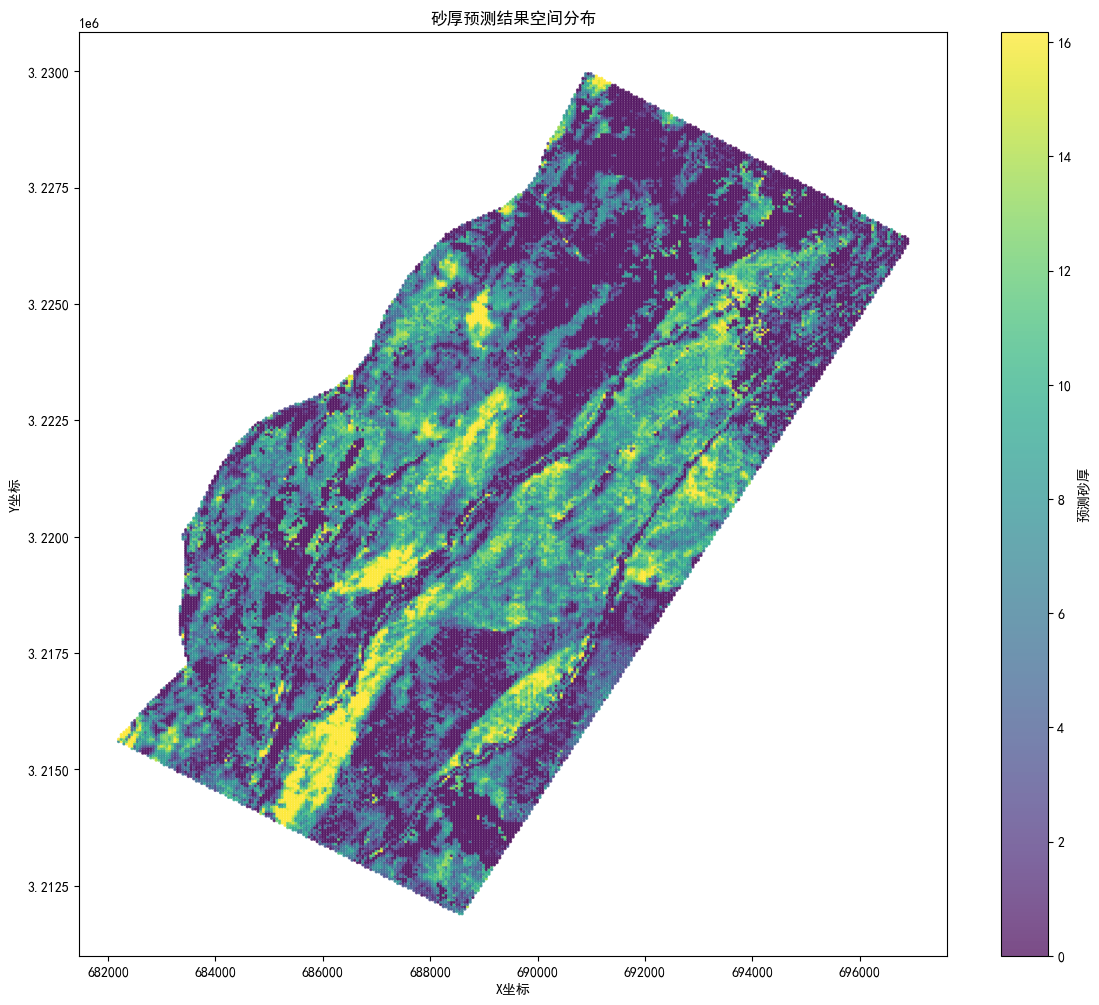

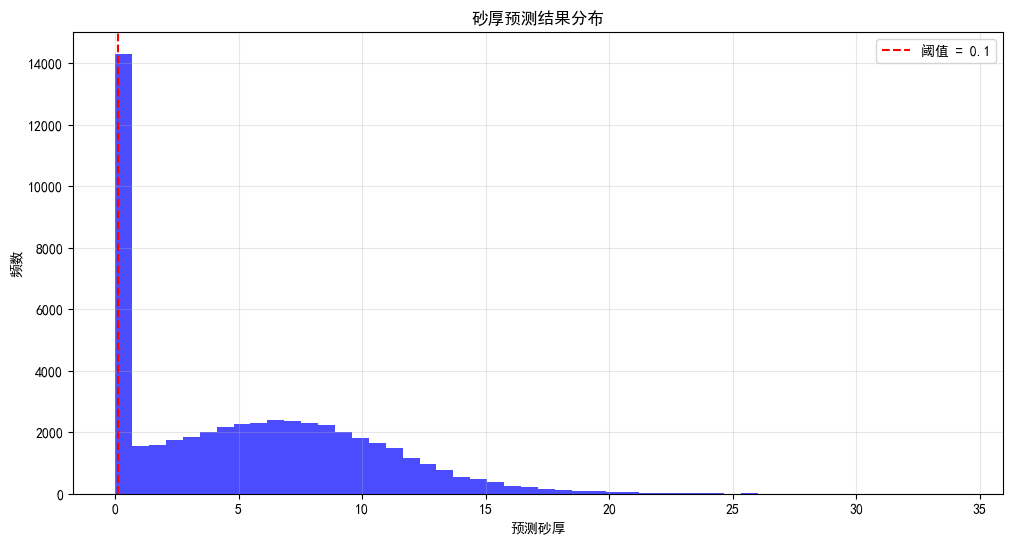

预测结果已保存为Petrel可导入的XYZ格式: svr_models_comparison\model_扩容数据_sand_thickness_petrel.txt
======== 砂厚预测完成 ========

==== 使用扩容数据+模式识别模型进行预测 ====
模型R²: 0.6621
======== 开始预测砂厚 ========
数据点数: 51714
使用模型预测51714个点的砂厚...
有5452个点的预测砂厚为负值，已将其置为0

预测结果统计:
  - 总点数: 51714
  - 预测砂厚≤0.1的点数: 5676 (10.98%)
  - 预测砂厚>0.1的点数: 46038 (89.02%)
  - 平均预测砂厚: 9.6659
  - 最大预测砂厚: 43.2116

预测结果已保存到文件: svr_models_comparison\model_扩容数据_模式识别_sand_thickness.csv


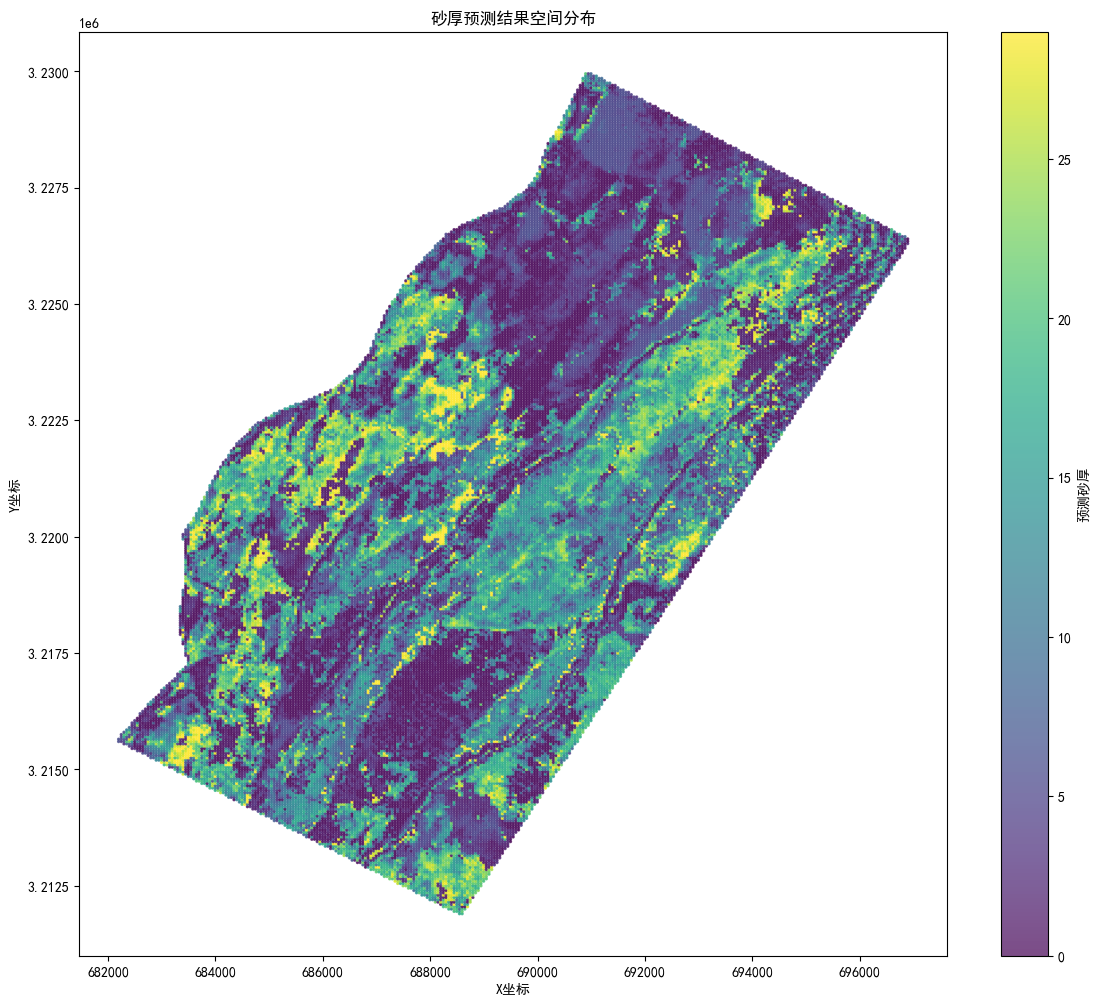

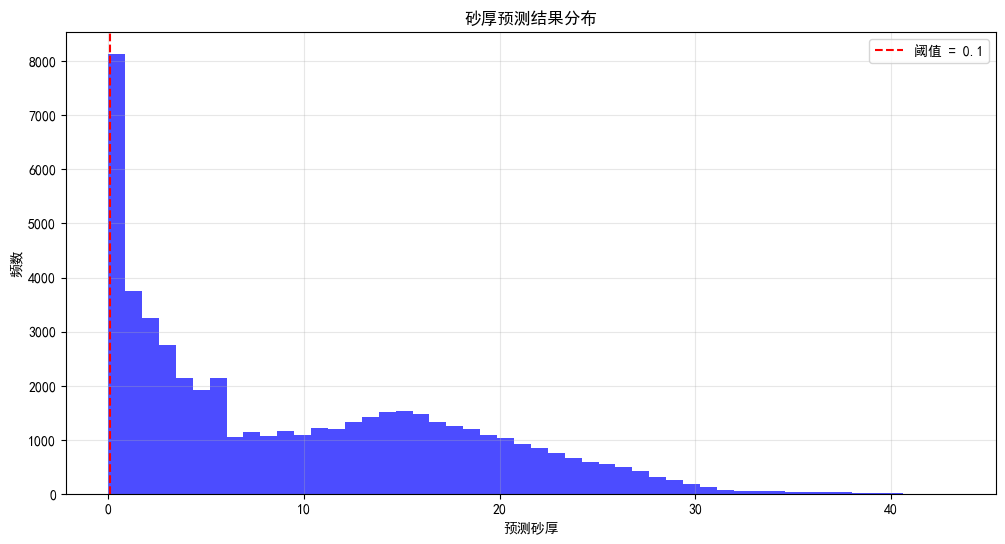

预测结果已保存为Petrel可导入的XYZ格式: svr_models_comparison\model_扩容数据_模式识别_sand_thickness_petrel.txt
======== 砂厚预测完成 ========


In [16]:
# 使用每个模型对全体地震数据进行预测
print("\n======== 使用所有模型进行全区域预测 ========")

for model_info in models:
    model_name = model_info["name"]
    model_results = model_info["results"]

    print(f"\n==== 使用{model_name}模型进行预测 ====")
    print(f"模型R²: {model_results['metrics']['r2']:.4f}")

    # 为每个模型创建单独的预测文件名前缀
    filename_prefix = f"model_{model_name.replace('+', '_').replace(' ', '_').lower()}"

    # 进行预测
    predictions = predict_with_model(
        model_results=model_results,
        data=seismic_data_encoded,
        coords_columns=["X", "Y", "Z"],
        output_dir=model_comparison_dir,
        filename_prefix=filename_prefix,
        threshold_zero=0.1,
        verbose=True,
    )